In [88]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
fitter = fitting.LinearLSQFitter()
from scipy.ndimage import median_filter
from scipy.interpolate import interp1d


In [89]:
fname='../../Type1/OGLEJ050650.94-700052.7/ADP.2020-11-16T16:11:14.683.fits'
harps='../../Type1/OGLEJ050650.94-700052.7/HARPS2005/ADP.2014-10-02T10:01:36.517.fits'
mucent='../../Mu_Centauri/ADP.2016-09-21T11:56:32.916.fits'

In [90]:
#fits.getheader(mucent)

In [91]:
fits.info(fname)

Filename: ../../Type1/OGLEJ050650.94-700052.7/ADP.2020-11-16T16:11:14.683.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1011   ()      
  1  SPECTRUM      1 BinTableHDU     71   1R x 6C   [131644D, 131644E, 131644E, 131644E, 131644E, 131644E]   


In [92]:
#plt.figure(figsize=(20,20))
#plt.imshow(fits.getdata(fname3).T[600:800],norm='log',vmin=200,aspect=10)
xd = fits.getdata(fname)
cent=fits.getdata(mucent)
harps=fits.getdata(harps)

In [93]:
#UVES
xd_new=xd['FLUX'][0][4145:-1719].tolist()
xd_filt=median_filter(xd_new,200)
lam = xd['WAVE'][0][4145:-1719]

mask_alpha=np.abs(6562.8-lam)>40
mask_beta=np.abs(4861.33333333333-lam)>40
mask_gamma=np.abs(4367.23-lam)>50 #H_gamma está corrido
mask=mask_alpha&mask_beta&mask_gamma

#HARPS
xdH_new=harps['FLUX'][0][4145:-1719].tolist()
xdH_filt=median_filter(xdH_new,450)
lamH = harps['WAVE'][0][4145:-1719]

mask_alphaH=np.abs(6562.8-lamH)>40
mask_betaH=np.abs(4861.33333333333-lamH)>40
mask_gammaH=np.abs(4367.23-lamH)>50 #H_gamma está corrido
maskH=mask_alphaH&mask_betaH&mask_gammaH


#MuCen
cent_new=cent['FLUX'][0][4145:-1719].tolist()
cent_filt=median_filter(cent_new,300)
lamc = cent['WAVE'][0][4145:-1719]

mask_alphac=np.abs(6562.8-lamc)>40
mask_betac=np.abs(4861.33333333333-lamc)>40
mask_gammac=np.abs(4367.23-lamc)>50 #H_gamma está corrido
maskc=mask_alphac&mask_betac&mask_gammac

In [94]:
modelo = fitter(models.Chebyshev1D(25),lam[mask],xd_filt[mask])
modeloH = fitter(models.Chebyshev1D(25),lamH[maskH],xdH_filt[maskH])
modeloc = fitter(models.Chebyshev1D(25),lamc[maskc],cent_filt[maskc])
xd_filt[mask]

array([ 98.89922333,  98.89922333,  98.89922333, ..., 126.10077667,
       126.33982086, 126.33982086], shape=(115451,))

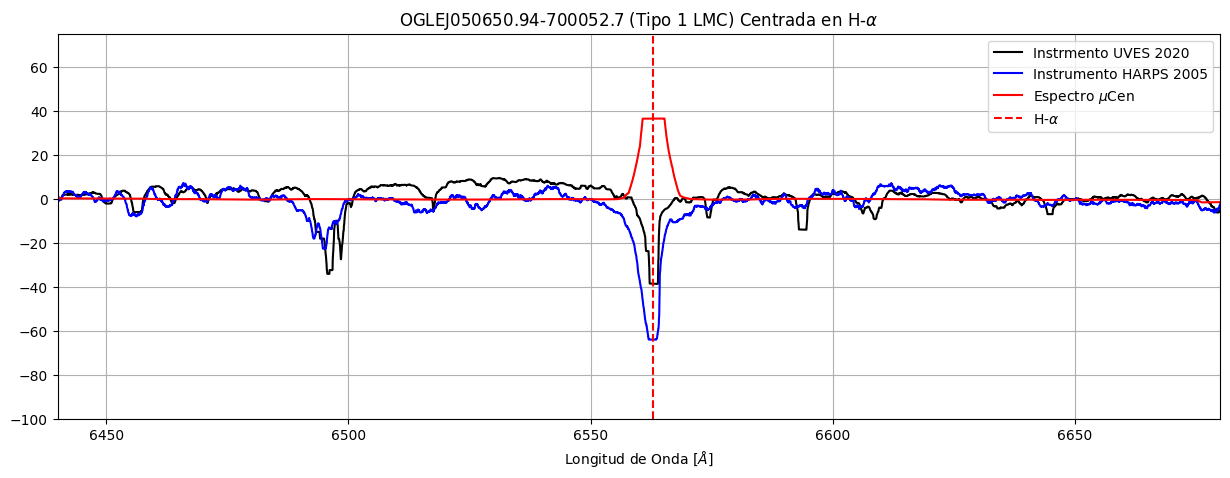

In [112]:
plt.figure(figsize=(15,5))
plt.plot(lam-5,xd_filt-modelo(lam), color='black', label='Instrmento UVES 2020')
plt.plot(lamH-5,xdH_filt-modeloH(lamH), color='blue', label='Instrumento HARPS 2005')
plt.plot(lamc,(cent_filt-modeloc(lamc))*10,color='red', label=r'Espectro $\mu$Cen')

plt.ylim(-100,75)
plt.xlim(6440,6680)#H-alpha
plt.axvline(x=6562.8, color='r', linestyle='--', label=r'H-$\alpha$ ')
plt.xlabel(r'Longitud de Onda [$\AA$]')
plt.legend()
plt.title(r'OGLEJ050650.94-700052.7 (Tipo 1 LMC) Centrada en H-$\alpha$')
plt.margins(x=0)
plt.grid(True)
plt.savefig('harps_uves_type1LMC')

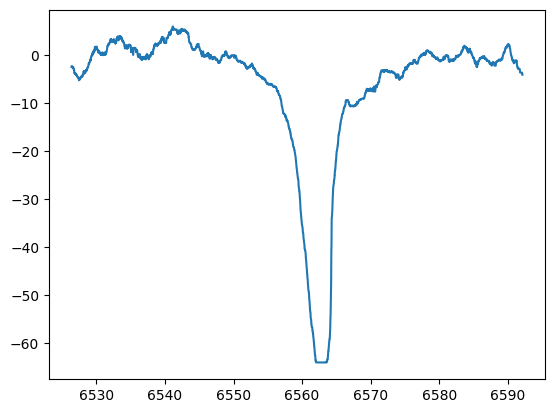

In [87]:
xU=(lam-5).tolist()[110540:-12849]
yU=(xd_filt-modelo(lam)).tolist()[110540:-12849]
xH=(lamH-5).tolist()[270840:-29849]
yH=(xdH_filt-modeloH(lamH)).tolist()[270840:-29849]

plt.plot(xH,yH)

In [97]:
def center_half_min(x, y):
    # Índice del mínimo absoluto (pico de absorción)
    min_idx = np.argmin(y)
    min_x = x[min_idx]
    min_y = y[min_idx]

    # Nivel de media altura (mitad entre mínimo y los bordes locales)
    # Definimos altura media entre mínimo y el promedio de los puntos vecinos al mínimo
    left = y[:min_idx]
    right = y[min_idx+1:]
    baseline = (np.mean(left[-5:]) + np.mean(right[:5])) / 2  # aproximación del continuo
    half_depth = (baseline + min_y) / 2

    # Interpolamos para encontrar los cruces a media altura
    f_interp = interp1d(x, y - half_depth, kind='linear')
    x_dense = np.linspace(x[0], x[-1], 10000)
    y_dense = f_interp(x_dense)

    # Encontramos puntos donde la curva cruza el nivel de media altura
    crossings = np.where(np.diff(np.sign(y_dense)))[0]
    if len(crossings) >= 2:
        x1 = x_dense[crossings[0]]
        x2 = x_dense[crossings[-1]]
        center = (x1 + x2) / 2
        return center, x1, x2
    else:
        return min_x, None, None  # fallback si no hay dos cruces


Centro a media altura U: 6563.052394613959
Centro a media altura H: 6562.782803280328
Distancia entre centros a media altura: 0.2695913336310696


<Figure size 1500x500 with 0 Axes>

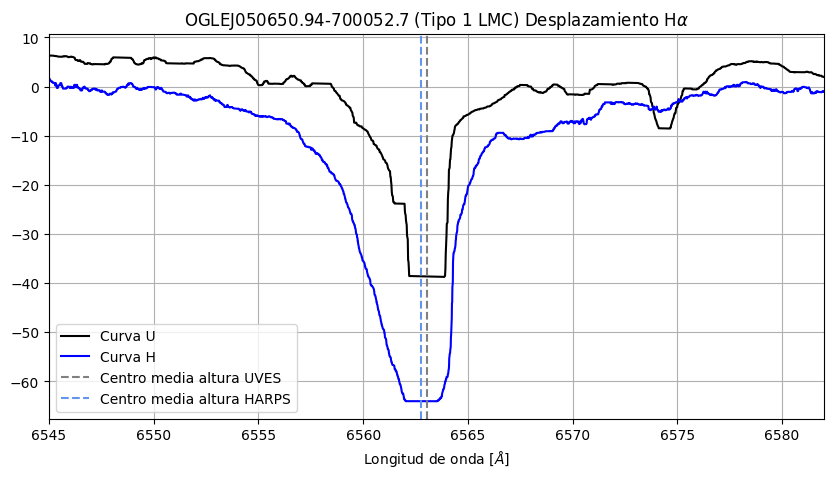

<Figure size 640x480 with 0 Axes>

In [116]:
center_U, left_U, right_U = center_half_min(xU, yU)
center_H, left_H, right_H = center_half_min(xH, yH)

distance = abs(center_H - center_U)

print(f"Centro a media altura U: {center_U}")
print(f"Centro a media altura H: {center_H}")
print(f"Distancia entre centros a media altura: {distance}")

plt.figure(figsize=(15,5))
plt.figure(figsize=(10, 5))
plt.plot(xU, yU, label='Curva U', color='black')
plt.plot(xH, yH, label='Curva H',color='blue')
plt.axvline(center_U, color='gray', linestyle='--', label='Centro media altura UVES')
plt.axvline(center_H, color='cornflowerblue', linestyle='--', label='Centro media altura HARPS')
plt.xlabel(r"Longitud de onda [$\AA$]")
#plt.ylabel("Amplitud")
plt.legend()
plt.xlim(6545,6582)
plt.title(r"OGLEJ050650.94-700052.7 (Tipo 1 LMC) Desplazamiento H$\alpha$")
plt.grid(True)
plt.show()
plt.savefig('DistanceH')
